# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

Столбцы имеют следующие названия:
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Откройте и изучите файл

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report

In [2]:
users_behavior = pd.read_csv('/datasets/users_behavior.csv')
users_behavior

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


In [3]:
users_behavior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
users_behavior.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Посмотрели на нашу таблицу, обратили внимание на наличие нулевых значений.
Возможно можно было сделать предобработку данных, но проверим без нее.

In [5]:
users_behavior.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


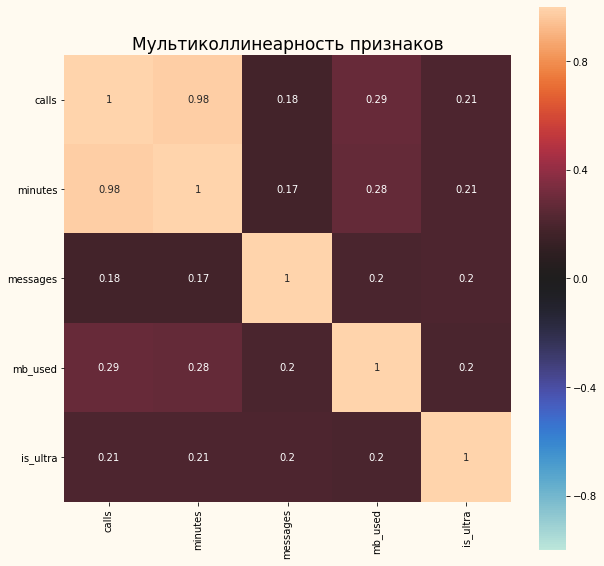

In [6]:
fig, ax = plt.subplots()
sns.heatmap(users_behavior.corr(),vmin=-1, vmax=1, center= 0,square=True,annot=True)
ax.set_facecolor('seashell')
fig.set_figwidth(10)
fig.set_figheight(10)
fig.set_facecolor('floralwhite')
plt.title('Мультиколлинеарность признаков', fontsize=17)
plt.show()

У нас есть два сильносвязанных столбца, для лучшего обучения один из них мы удалим.

## Разбейте данные на выборки

In [7]:
features=users_behavior.drop(['is_ultra','calls'], axis=1)
target=users_behavior['is_ultra']

Разделили нашу таблицу на две части: обучищий набор и целевой признак.

In [8]:
features_new, features_valid, target_new, target_valid = train_test_split(
    features, target, test_size=0.2,train_size=0.8, random_state=12345)

Сделали две выборки в отношении 20% на 80%: новую и валидационную.

In [9]:
features_train, features_test, target_train, target_test = train_test_split(
    features_new, target_new, test_size=0.25,train_size=0.75, random_state=12345)

Новую поделили еще в отношении 1 на 4. И получили 60% от общих данных для тренировки и 20% для теста.

In [10]:
print(features_train.shape,target_valid.shape,features_test.shape)

(1928, 3) (643,) (643, 3)


Размеры выборок соответствуют нашим ожиданиям.

## Исследуйте модели

### Решающее дерево

In [11]:
best_model = None
best_result = 0
for crit in ['gini','entropy']:
    for split in range(2,10):
        for leaf in range(1,20):
            for depth in range(1, 10):
                model = DecisionTreeClassifier(random_state=12345, max_depth=depth,criterion=crit,min_samples_split=split,min_samples_leaf=leaf)
                model.fit(features_train,target_train)
                predictions = model.predict(features_valid)
                result = accuracy_score(target_valid, predictions)
                if result > best_result:
                    best_model = model
                    best_result = result
                    best_depth=depth
                    best_crit=crit
                    best_split=split
                    best_leaf=leaf
print('Лучший результат:',best_result)
print('При глубине дерева',best_depth,', критерии',best_crit,', количества узлов',best_split,'и числа объектов в узлах',best_leaf)

Лучший результат: 0.8009331259720062
При глубине дерева 6 , критерии entropy , количества узлов 2 и числа объектов в узлах 1


### Случайный лес

In [12]:
best_esti=0
best_depth=0
best_crit=0
for crit in ['gini','entropy']:
    for depth in range(1, 11):
        for esti in range(10, 51,10):
            model = RandomForestClassifier(random_state=12345, n_estimators=esti,max_depth=depth,criterion=crit) 
            model.fit(features_train,target_train) 
            predictions = model.predict(features_valid) 
            result = accuracy_score(target_valid, predictions)
            if result > best_result:
                best_model = model
                best_result = result
                best_depth=depth
                best_crit=crit
                best_esti=esti
print('Лучший результат:',best_result)
if best_esti==0:
    print('Эти модели были хуже')
else:
    print('При глубине дерева',best_depth,', критерии',best_crit,'и количества деревьев',best_esti)

Лучший результат: 0.8040435458786936
При глубине дерева 8 , критерии entropy и количества деревьев 20


### Логистическая регрессия

In [13]:
indicator=0
model = LogisticRegression(random_state=12345) 
model.fit(features_train,target_train) 
predictions = model.predict(features_valid) 
result = accuracy_score(target_valid, predictions)
if result > best_result:
    best_model = model
    best_result = result
    indicator=1
print('Лучший результат:',best_result)
if indicator==0:
    print('Эта модель была хуже')
else:
    print('Эта модель была лучше')

Лучший результат: 0.8040435458786936
Эта модель была хуже


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Вывод

Решающее дерево для этой задачи нам подошло лучше всего. На валидационной выборке получили результат в 80%.

## Проверьте модель на тестовой выборке

In [14]:
features_train.append(features_valid)

,minutes,messages,mb_used
2656,185.07,34.0,17166.53
823,290.69,77.0,21507.03
2566,289.83,15.0,22151.73
1451,333.49,50.0,17275.47
2953,300.39,69.0,17277.83
...,...,...,...
2061,478.48,0.0,16962.58
1510,334.24,91.0,11304.14
2215,436.68,52.0,12311.24
664,739.27,124.0,22818.56


In [15]:
model = RandomForestClassifier(random_state=12345, n_estimators=best_esti,max_depth=best_depth,criterion=best_crit) 
model.fit(features_train.append(features_valid),target_train.append(target_valid)) 
predictions = model.predict(features_valid) 
result = accuracy_score(target_valid, predictions)
result

0.8413685847589425

In [16]:
predictions = model.predict(features_test) 
result = accuracy_score(target_test, predictions)
result

0.7822706065318819

С тестовой выборкой наша модель тоже справилась хорошо, 78 %.

## (бонус) Проверьте модели на адекватность

In [17]:
features_adept=features_test['minutes']*0
features_adept

2699    0.0
242     0.0
2854    0.0
1638    0.0
1632    0.0
       ... 
2551    0.0
1261    0.0
1658    0.0
353     0.0
1806    0.0
Name: minutes, Length: 643, dtype: float64

In [18]:
result = accuracy_score(target_test, features_adept)
result

0.6889580093312597

Заполнили всю выборку нулями и получили точнось целых 68 проценетов. Из этого можно сделать выбор, что наша выборка сильно несбалансированна и рандомная модель может выдать почти 70%.

In [19]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(features_valid, target_valid)
dummy_clf.score(features_valid, target_valid)

0.6951788491446346

Модель с выбором наиболее частого варианта дала нам почти 70%

In [20]:
users_behavior['is_ultra'].value_counts(normalize=True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

Баланс тарифов почти 70 на 30.

## Вывод

Наша исходная выборка оказалась сильно несбалансирована, что даже с случайной моделью мы получаем 70%.
Смогли перебрать несклько типов моделей с разными гиперпараметрами, в итоге лучшим вариантов оказалась модель "Случайный лес", затем переобучили можель на более большой выборке и провели тесты на тестовой выборке. Показали результат в 78%, всего на 8% лучше, чем модель, которая всегда поставляет самый частый вариант.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
